In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score




#TRAIN LOADER


#data = pd.read_csv(r'.\OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', sep='\t', names=['id','sentence', 'label1','label2', 'label3'])  #Francesco esecution
train_data = pd.read_csv('/content/OLID_Tain_ATUSER_URL_EmojiRemoved_Pedro.txt', delimiter='\t', skiprows=1, names=['id', 'sentence', 'label1', 'label2', 'label3']) # Nebos line

data = data.drop(axis = 1, labels = ['id','label2','label3'])
data = data.drop(axis=0, index=0 )

# checking how many pos and neg reviews
review_counts = data['label1'].value_counts()
print(f'Count of reviews by sentiment: {review_counts}')

print()
for index, row in data.iterrows():
    if row['label1'] == 'OFF':
        data.at[index, 'label1'] = 0  # for the OFF tweets
    else:
        data.at[index, 'label1'] = 1 # for the NOT tweets

# checking how many pos and neg reviews
review_counts = data['label1'].value_counts()
print(f'Count of reviews by sentiment: {review_counts}')



nltk.download('punkt')
data['tokens'] = data['sentence'].apply(word_tokenize)


# create a vocabulary and map tokens to indices
vocab = {word: idx for idx, word in enumerate(set(word for sentence in data['tokens'] for word in sentence), 1)}
data['indexed'] = data['tokens'].apply(lambda x: [vocab[word] for word in x])


# pad sequences to a maximum length
max_len = max(len(sentence) for sentence in data['indexed'])
data['padded'] = data['indexed'].apply(lambda x: x + [0]*(max_len - len(x)))

# convert to tensord and split dataset
features = torch.tensor(data['padded'].tolist())
labels = torch.tensor(data['label1'].tolist())


train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.2, random_state=42)

train_data = TensorDataset(train_features, train_labels)
test_data = TensorDataset(test_features, test_labels)
train_loader = DataLoader(train_data, batch_size=10)
test_loader = DataLoader(test_data, batch_size=10)


Count of reviews by sentiment: label1
NOT    12894
OFF     6427
Name: count, dtype: int64

Count of reviews by sentiment: label1
1    12895
0     6427
Name: count, dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


1546
387


In [12]:
# BiLSTM model
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(BiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        output = self.fc(hidden)
        return output

In [13]:
# Hyperparameters
vocab_size = len(vocab) + 1  # plus one for padding index
embedding_dim = 100
hidden_dim = 128
output_dim = 2  # inary classification

model = BiLSTM(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

# GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BiLSTM(
  (embedding): Embedding(24688, 100)
  (lstm): LSTM(100, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)

In [14]:
def train_model(model, train_loader, optimizer, loss_fn, epochs=10):
    model.train()
    for epoch in range(epochs):
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(texts)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')


train_model(model, train_loader, optimizer, loss_fn)

Epoch 1, Loss: 0.7006499171257019
Epoch 2, Loss: 0.3721248507499695
Epoch 3, Loss: 0.08900414407253265
Epoch 4, Loss: 0.024192508310079575
Epoch 5, Loss: 0.0106154540553689
Epoch 6, Loss: 0.0034612517338246107
Epoch 7, Loss: 0.0012263011885806918
Epoch 8, Loss: 0.001110078184865415
Epoch 9, Loss: 0.002798511879518628
Epoch 10, Loss: 0.0006962298648431897


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.76      0.79      1288
           1       0.88      0.91      0.90      2577

    accuracy                           0.86      3865
   macro avg       0.85      0.84      0.84      3865
weighted avg       0.86      0.86      0.86      3865

Confusion Matrix
[[ 977  311]
 [ 223 2354]]
ROC AUC Score:
0.8897922255403148


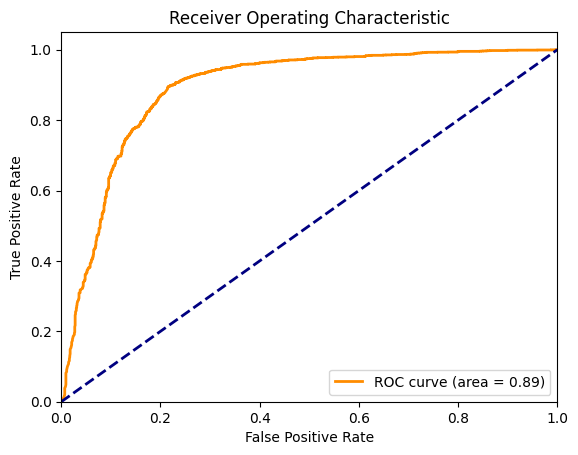

'\nClass-wise results: \nEach row under the class labels (like 0 and 1 in your case, \ntypically representing different classes such as "OFF" and "NOT") \nshows the precision, recall, F1 score, and support for that class.\n\nAccuracy: \nThis is the ratio of correctly predicted observations \nto the total observations and is provided separately.\n\nMacro average: \nThis is calculated by taking the average of\nthe precision, recall, and F1 score for each class, without taking support \ninto account. It treats all classes equally, regardless of how many instances\nthere are in each class.\n\nWeighted average: \nThis takes the average of the precision, recall, and F1 score \nfor each class, weighted by the support (the number of true instances for \neach class). This method accounts for class imbalance;\nit calculates metrics in which each class’s metric is weighted \nby its presence in the true data.\n'

In [19]:
from sklearn.metrics import classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []  # List to store probabilities for the positive class

    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            # Using softmax to calculate probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs).cpu().numpy()[:, 1]
            all_probs.extend(probs)

    # Calculate metrics
    print("Classification Report:")
    print(classification_report(all_labels, all_preds))
    print("Confusion Matrix")
    print(confusion_matrix(all_labels, all_preds))

    # ROC AUC and ROC Curve are applicable only for binary classification
    if output_dim == 2:
        roc_auc = roc_auc_score(all_labels, all_probs)
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

        print("ROC AUC Score:")
        print(roc_auc)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()

evaluate_model(model, test_loader)

'''
Class-wise results:
Each row under the class labels (like 0 and 1 in your case,
typically representing different classes such as "OFF" and "NOT")
shows the precision, recall, F1 score, and support for that class.

Accuracy:
This is the ratio of correctly predicted observations
to the total observations and is provided separately.

Macro average:
This is calculated by taking the average of
the precision, recall, and F1 score for each class, without taking support
into account. It treats all classes equally, regardless of how many instances
there are in each class.

Weighted average:
This takes the average of the precision, recall, and F1 score
for each class, weighted by the support (the number of true instances for
each class). This method accounts for class imbalance;
it calculates metrics in which each class’s metric is weighted
by its presence in the true data.
'''